<img src="https://github.com/djp840/MSDS_458_Public/blob/main/images2/NorthwesternHeader.png?raw=1" />

## MSDS458 Research Assignment 4 - Stock Prediction_Petkovski

### Import Packages

In [ ]:
from packaging import version
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
import re
import matplotlib.pyplot as plt
import string

import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow import keras
import tensorflow.keras.backend as k
from tensorflow.keras import models, layers, callbacks

import nltk
from nltk.corpus import stopwords
import time

from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

\### Verify TensorFlow version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.15.0


#Load Data

In [ ]:
# Read the stock data from yahoo finance
yf.pdr_override()
stock_list = ['LYFT']
end = datetime.now()
start = datetime(end.year - 2, end.month, end.day)

for stock in stock_list:
    globals()[stock] = yf.download(stock, start, end)

company_list = [LYFT]
company_name = ["LYFT"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

df = pd.concat(company_list, axis=0)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2022-05-11,18.950001,19.370001,17.520000,17.719999,17.719999,21542400,LYFT
2022-05-12,17.264999,19.004999,17.240000,18.590000,18.590000,16174800,LYFT
2022-05-13,18.860001,20.180000,18.860001,20.000000,20.000000,12841800,LYFT
2022-05-16,19.850000,20.030001,19.115000,19.139999,19.139999,9447600,LYFT
2022-05-17,19.510000,20.177999,19.129999,19.719999,19.719999,10205900,LYFT


In [ ]:
LYFT.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503 entries, 2022-05-11 to 2024-05-10
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          503 non-null    float64
 1   High          503 non-null    float64
 2   Low           503 non-null    float64
 3   Close         503 non-null    float64
 4   Adj Close     503 non-null    float64
 5   Volume        503 non-null    int64  
 6   company_name  503 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 31.4+ KB


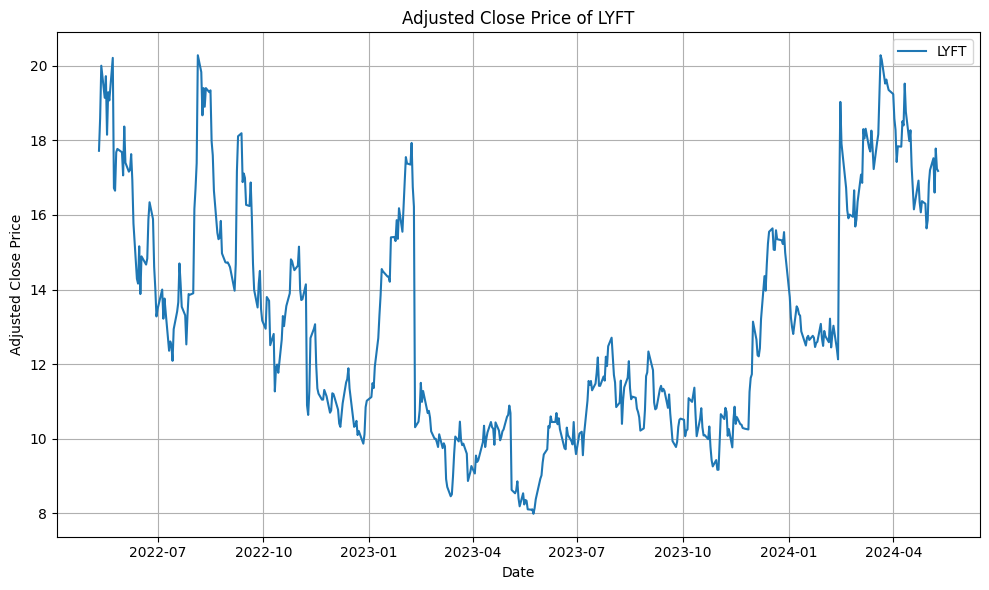

In [ ]:
# Plot the Adj Close price
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Adj Close'], label='LYFT')
plt.title('Adjusted Close Price of LYFT')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


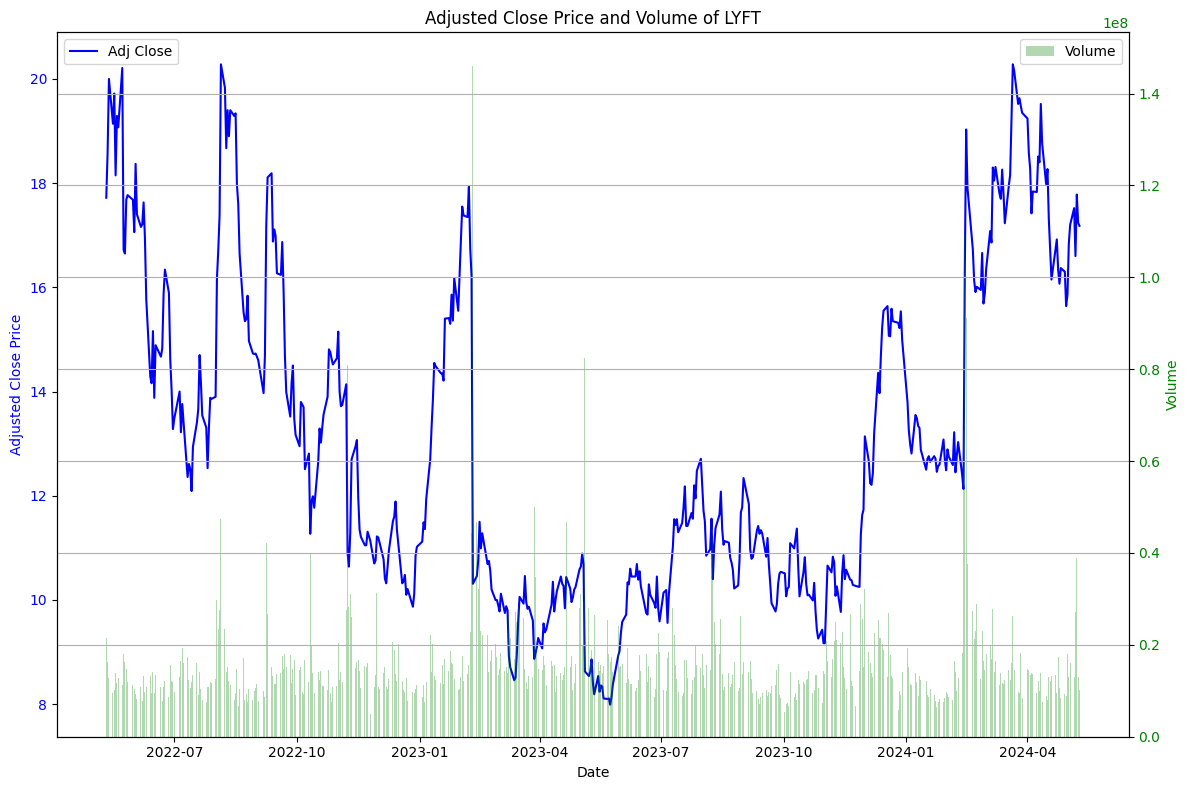

In [ ]:
# Plot the Adj Close price and Volume
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(df.index, df['Adj Close'], label='Adj Close', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Adjusted Close Price', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Adjusted Close Price and Volume of LYFT')

#second y-axis for Volume
ax2 = ax1.twinx()
ax2.bar(df.index, df['Volume'], label='Volume', color='g', alpha=0.3)
ax2.set_ylabel('Volume', color='g')
ax2.tick_params(axis='y', labelcolor='g')

#legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
data = df.filter(['Close'])
data.shape


(504, 1)

In [ ]:
#convert to numpy arrays
dataset = data.values

In [ ]:
#scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

scaled_data [:5]

array([[0.90724156],
       [0.95443439],
       [0.82668829],
       [0.91944673],
       [0.9015459 ]])

In [ ]:
# Set the size for training data
training_size = int(len(dataset) * 0.80)
test_size = len(dataset) - training_size

# Split the data into training and test sets
train_data = scaled_data[:training_size]
test_data = scaled_data[training_size:]

# Further split the training data into training and validation sets
validation_size = int(len(train_data) * 0.20)  # 20% of the training data
train_data, val_data = train_data[:-validation_size], train_data[-validation_size:]

# Print sizes for verification
print(f"Training size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")

# Optional: Print shapes to debug
print(f"Train data shape: {train_data.shape}, Validation data shape: {val_data.shape}, Test data shape: {test_data.shape}")


Training size: 323, Validation size: 80, Test size: 101
Train data shape: (323, 1), Validation data shape: (80, 1), Test data shape: (101, 1)


In [ ]:
# Define time step
time_step = 30

# Function to convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]   # Create sequences
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Create the training dataset
x_train, y_train = create_dataset(train_data, time_step)
# Create the validation dataset
x_val, y_val = create_dataset(val_data, time_step)
# Create the testing dataset
x_test, y_test = create_dataset(test_data, time_step)

# Print shapes for verification
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")


x_train shape: (292, 30), y_train shape: (292,)
x_val shape: (49, 30), y_val shape: (49,)
x_test shape: (70, 30), y_test shape: (70,)


In [ ]:
# Reshape the datasets to be [samples, time steps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [ ]:
# Print shapes after reshaping for verification
print(f"x_train shape after reshape: {x_train.shape}")
print(f"x_val shape after reshape: {x_val.shape}")
print(f"x_test shape after reshape: {x_test.shape}")

x_train shape after reshape: (292, 30, 1)
x_val shape after reshape: (49, 30, 1)
x_test shape after reshape: (70, 30, 1)


#Experiment 1_2 layers

In [ ]:
# Define callbacks
model_callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM_best_model.h5", save_best_only=True, monitor='val_loss', verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)
]


In [ ]:
# Build the LSTM model
model = models.Sequential()
model.add(layers.LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(64, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117619 (459.45 KB)
Trainable params: 117619 (459.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model with validation data and callbacks
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=1,
    epochs=50,
    callbacks=model_callbacks
)


Epoch 1/50
285/291 [============================>.] - ETA: 0s - loss: 0.0159
Epoch 1: val_loss improved from inf to 0.00398, saving model to LSTM_best_model.h5
291/291 [==============================] - 10s 10ms/step - loss: 0.0156 - val_loss: 0.0040
Epoch 2/50
 17/291 [>.............................] - ETA: 1s - loss: 0.0027

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


284/291 [============================>.] - ETA: 0s - loss: 0.0091
Epoch 2: val_loss improved from 0.00398 to 0.00285, saving model to LSTM_best_model.h5
291/291 [==============================] - 2s 7ms/step - loss: 0.0091 - val_loss: 0.0028
Epoch 3/50
289/291 [============================>.] - ETA: 0s - loss: 0.0083
Epoch 3: val_loss improved from 0.00285 to 0.00250, saving model to LSTM_best_model.h5
291/291 [==============================] - 3s 9ms/step - loss: 0.0083 - val_loss: 0.0025
Epoch 4/50
290/291 [============================>.] - ETA: 0s - loss: 0.0054
Epoch 4: val_loss did not improve from 0.00250
291/291 [==============================] - 4s 15ms/step - loss: 0.0054 - val_loss: 0.0035
Epoch 5/50
289/291 [============================>.] - ETA: 0s - loss: 0.0056
Epoch 5: val_loss improved from 0.00250 to 0.00176, saving model to LSTM_best_model.h5
291/291 [==============================] - 4s 13ms/step - loss: 0.0056 - val_loss: 0.0018
Epoch 6/50
290/291 [=================

In [ ]:
# Evaluate the model on the training dataset
train_loss = model.evaluate(x_train, y_train, verbose=0)
print(f"Training Loss: {train_loss:.4f}")

# Evaluate the model on the validation dataset
val_loss = model.evaluate(x_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")

# Evaluate the model on the test dataset
test_loss = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")

Training Loss: 0.0040
Validation Loss: 0.0021
3/3 [==============================] - 0s 7ms/step - loss: 0.0112
Test Loss: 0.0112


In [ ]:
# Make predictions on the test set
y_pred = model.predict(x_test)

3/3 [==============================] - 1s 7ms/step


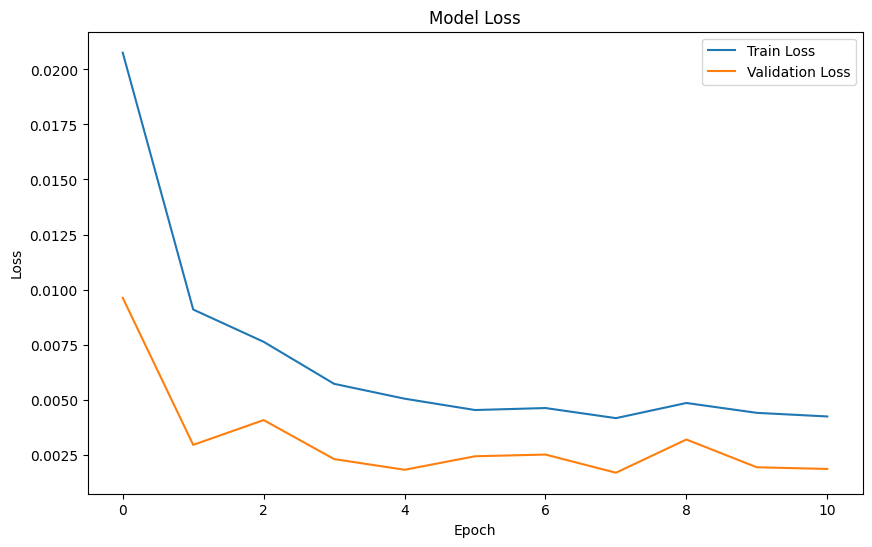

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

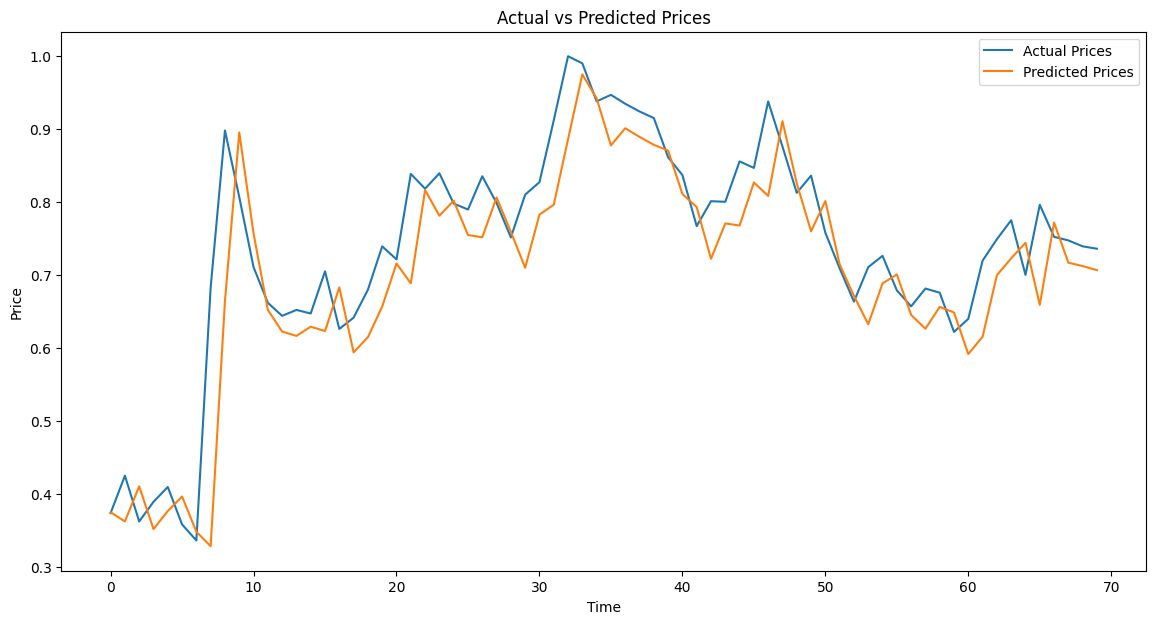

In [ ]:
# Plot actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices')
plt.title('Actual vs Predicted Prices_LYFT')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

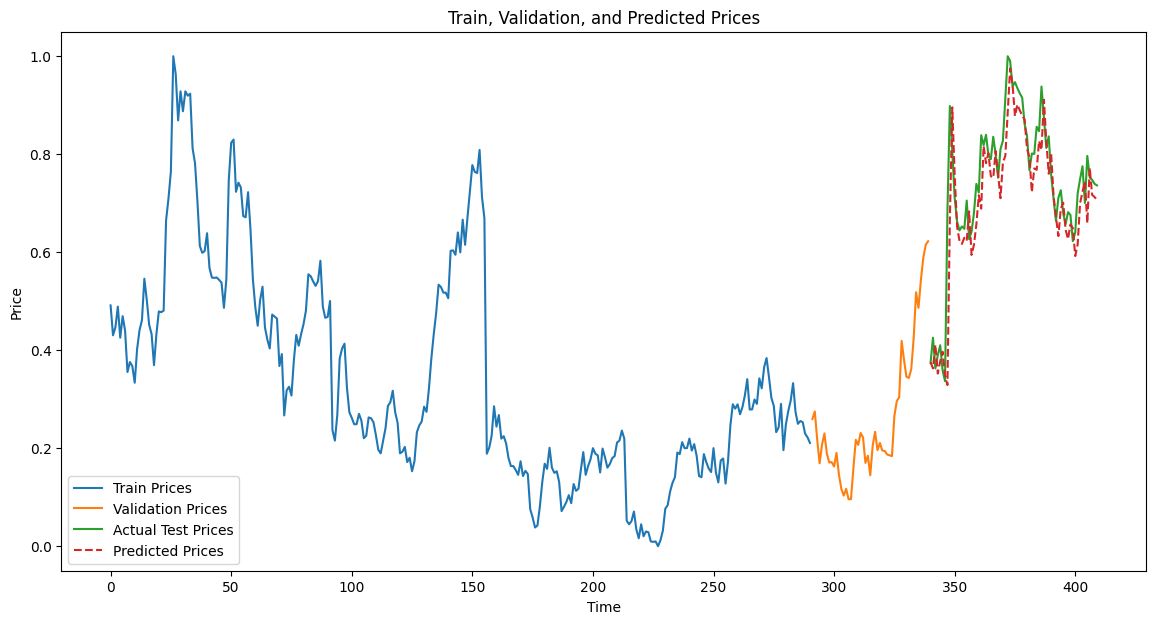

In [ ]:
# Create a placeholder for the full timeline
full_time = np.arange(len(y_train) + len(y_val) + len(y_test))

# Concatenate the train, validation, and test data along the timeline
full_y_train = np.concatenate([y_train, np.full(len(y_val) + len(y_test), np.nan)])
full_y_val = np.concatenate([np.full(len(y_train), np.nan), y_val, np.full(len(y_test), np.nan)])
full_y_test = np.concatenate([np.full(len(y_train) + len(y_val), np.nan), y_test])
full_y_pred = np.concatenate([np.full(len(y_train) + len(y_val), np.nan), y_pred.flatten()])

# Plot training, validation, and predicted prices
plt.figure(figsize=(14, 7))
plt.plot(full_time, full_y_train, label='Train Prices')
plt.plot(full_time, full_y_val, label='Validation Prices')
plt.plot(full_time, full_y_test, label='Actual Test Prices')
plt.plot(full_time, full_y_pred, label='Predicted Prices', linestyle='dashed')
plt.title('Train, Validation, and Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
# Predict on the test set
y_pred_scaled = model.predict(x_test)

# Inverse transform the predictions
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform([y_test]).flatten()

# Prepare DataFrame for plotting
train_dates = data.index[:training_size-validation_size]  # Adjust for validation split
val_dates = data.index[training_size-validation_size:training_size]
test_dates = data.index[training_size+time_step+1:]

train_df = pd.DataFrame({'Date': train_dates, 'Close': data.loc[train_dates, 'Close']})
val_df = pd.DataFrame({'Date': val_dates, 'Close': data.loc[val_dates, 'Close']})
test_df = pd.DataFrame({'Date': test_dates, 'Close': y_test_actual, 'Predicted': y_pred.flatten()})



3/3 [==============================] - 0s 6ms/step


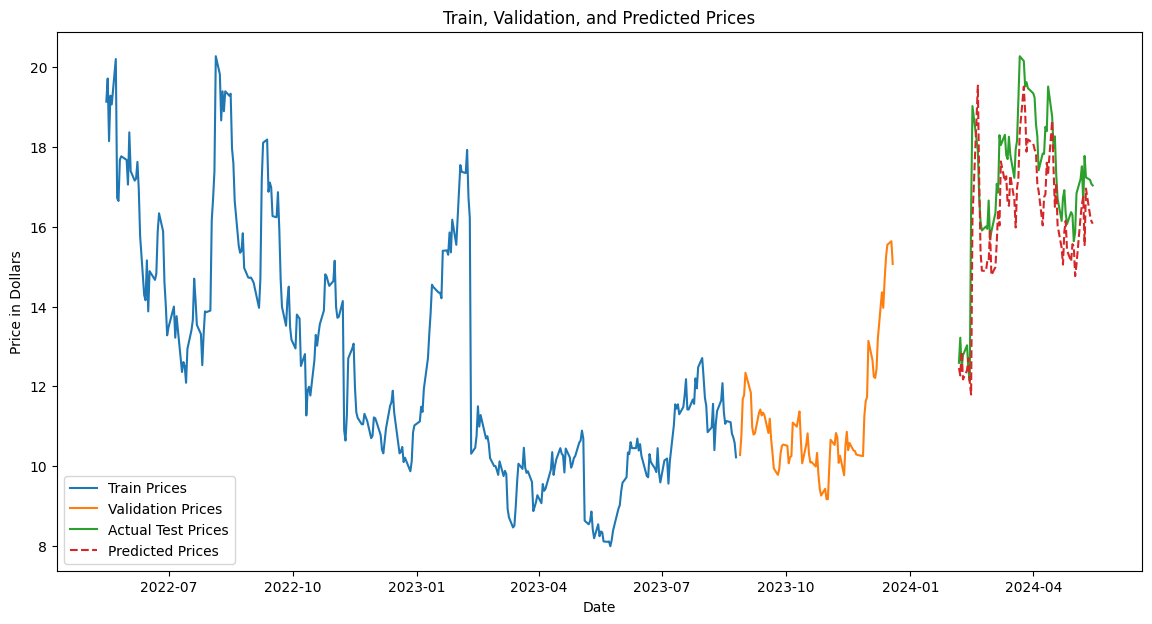

In [ ]:
# Plot the data in dollar values
plt.figure(figsize=(14, 7))
plt.plot(train_df['Date'], train_df['Close'], label='Train Prices')
plt.plot(val_df['Date'], val_df['Close'], label='Validation Prices')
plt.plot(test_df['Date'], test_df['Close'], label='Actual Test Prices')
plt.plot(test_df['Date'], test_df['Predicted'], label='Predicted Prices', linestyle='dashed')

plt.title('Train, Validation, and Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price in Dollars')
plt.legend()
plt.show()

In [ ]:
# Predict future prices for the next 10 days
future_predictions = []
last_sequence = x_test[-1]

for _ in range(50):
    next_pred = model.predict(last_sequence.reshape(1, time_step, 1))
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_pred)

# Inverse transform the future predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Prepare future dates
future_dates = pd.date_range(start=test_df['Date'].iloc[-1], periods=50)

# Debug print lengths
print(f"Length of future_dates: {len(future_dates)}")
print(f"Length of future_predictions: {len(future_predictions)}")
assert len(future_dates) == len(future_predictions), "Length mismatch between future_dates and future_predictions"

#DataFrame for future predictions
future_df = pd.DataFrame({'Date': future_dates, 'Predicted': future_predictions.flatten()})



1/1 [==============================] - 0s 21ms/step
Length of future_dates: 50
Length of future_predictions: 50


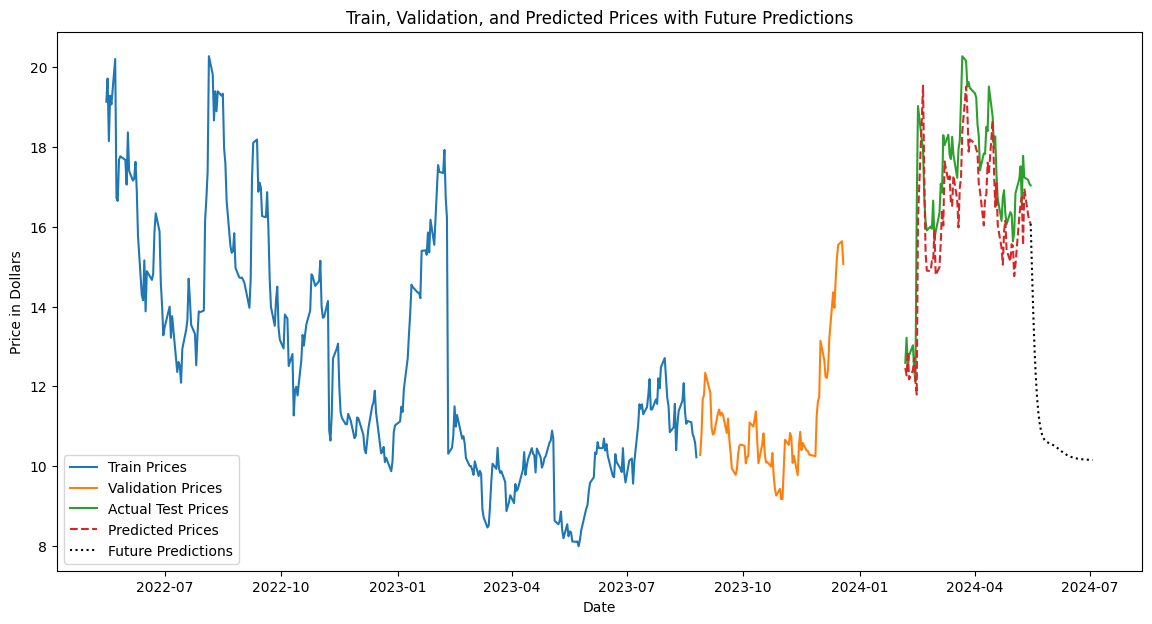

In [ ]:
# Plot the data
plt.figure(figsize=(14, 7))

# Plot train prices
plt.plot(train_df['Date'], train_df['Close'], label='Train Prices')

# Plot validation prices
plt.plot(val_df['Date'], val_df['Close'], label='Validation Prices')

# Plot actual test prices
plt.plot(test_df['Date'], test_df['Close'], label='Actual Test Prices')

# Plot predicted test prices
plt.plot(test_df['Date'], test_df['Predicted'], label='Predicted Prices', linestyle='dashed')

# Plot future predictions
plt.plot(future_df['Date'], future_df['Predicted'], label='Future Predictions', linestyle='dotted', color='black')

plt.title('Train, Validation, and Predicted Prices with Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price in Dollars')
plt.legend()
plt.show()

#LSTM_2 Layer n =50

In [ ]:
# Define time step
time_step = 50

# Function to convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]   # Create sequences
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Create the training dataset
x_train, y_train = create_dataset(train_data, time_step)
# Create the validation dataset
x_val, y_val = create_dataset(val_data, time_step)
# Create the testing dataset
x_test, y_test = create_dataset(test_data, time_step)

# Print shapes for verification
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

# Reshape the datasets to be [samples, time steps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)



x_train shape: (271, 50), y_train shape: (271,)
x_val shape: (29, 50), y_val shape: (29,)
x_test shape: (50, 50), y_test shape: (50,)


In [ ]:
# Build the LSTM model
model_1 = models.Sequential()
model_1.add(layers.LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model_1.add(layers.LSTM(64, return_sequences=False))
model_1.add(layers.Dense(25))
model_1.add(layers.Dense(1))

In [ ]:
# Define callbacks
model_callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM_best_model.h5", save_best_only=True, monitor='val_loss', verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)
]

In [ ]:
# Compile the model
model_1.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 128)           66560     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 25)                1625      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117619 (459.45 KB)
Trainable params: 117619 (459.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model with validation data and callbacks
history_1 = model_1.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=1, epochs=50, callbacks=model_callbacks)

Epoch 1/50
271/271 [==============================] - ETA: 0s - loss: 0.0212
Epoch 1: val_loss improved from inf to 0.00708, saving model to LSTM_best_model.h5
271/271 [==============================] - 7s 11ms/step - loss: 0.0212 - val_loss: 0.0071
Epoch 2/50
 12/271 [>.............................] - ETA: 2s - loss: 0.0032

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


267/271 [============================>.] - ETA: 0s - loss: 0.0093
Epoch 2: val_loss improved from 0.00708 to 0.00277, saving model to LSTM_best_model.h5
271/271 [==============================] - 3s 11ms/step - loss: 0.0093 - val_loss: 0.0028
Epoch 3/50
267/271 [============================>.] - ETA: 0s - loss: 0.0067
Epoch 3: val_loss improved from 0.00277 to 0.00258, saving model to LSTM_best_model.h5
271/271 [==============================] - 3s 11ms/step - loss: 0.0067 - val_loss: 0.0026
Epoch 4/50
269/271 [============================>.] - ETA: 0s - loss: 0.0063
Epoch 4: val_loss did not improve from 0.00258
271/271 [==============================] - 3s 11ms/step - loss: 0.0063 - val_loss: 0.0028
Epoch 5/50
266/271 [============================>.] - ETA: 0s - loss: 0.0056
Epoch 5: val_loss did not improve from 0.00258
271/271 [==============================] - 2s 8ms/step - loss: 0.0056 - val_loss: 0.0026
Epoch 6/50
268/271 [============================>.] - ETA: 0s - loss: 0.0049

In [ ]:
# Evaluate the model on the training dataset
train_loss_1 = model_1.evaluate(x_train, y_train, verbose=0)
print(f"Training Loss: {train_loss_1:.4f}")

# Evaluate the model on the validation dataset
val_loss_1 = model_1.evaluate(x_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss_1:.4f}")

# Evaluate the model on the test dataset
test_loss_1 = model_1.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss_1:.4f}")


Training Loss: 0.0056
Validation Loss: 0.0047
2/2 [==============================] - 0s 33ms/step - loss: 0.0169
Test Loss: 0.0169


In [ ]:
# Make predictions on the test set
y_pred_1 = model_1.predict(x_test)

2/2 [==============================] - 2s 12ms/step


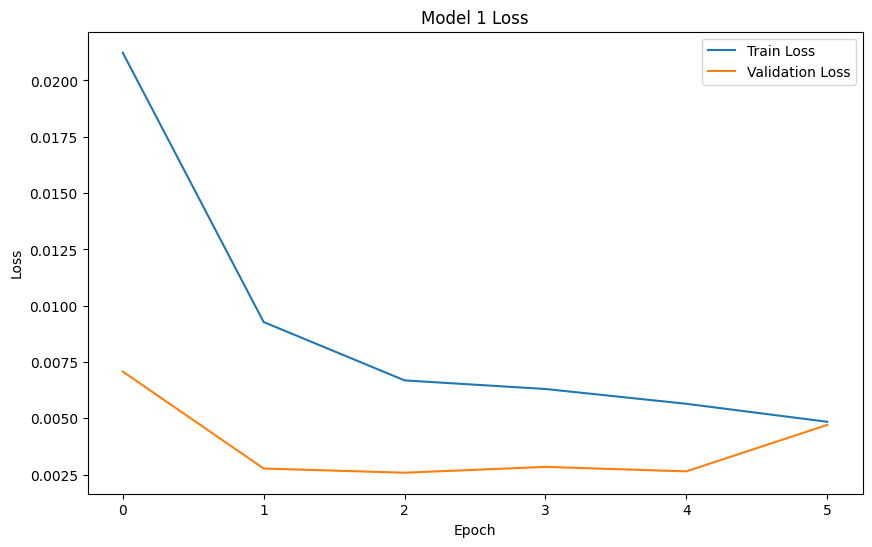

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Model 1 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


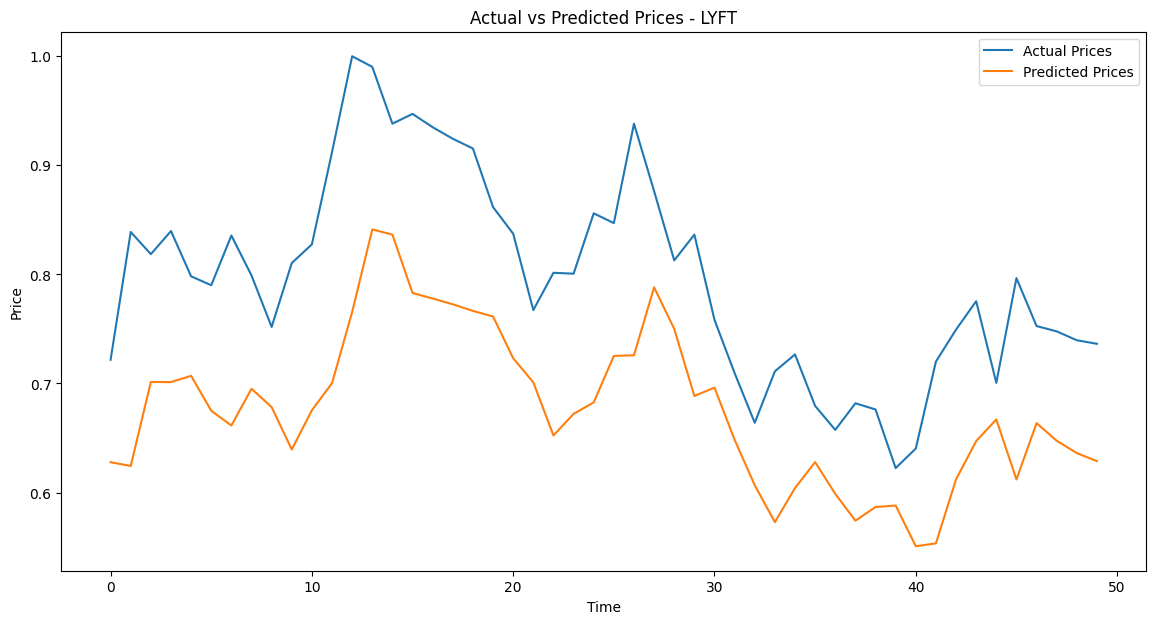

In [ ]:
# Plot actual vs. predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual Prices')
plt.plot(y_pred_1, label='Predicted Prices')
plt.title('Actual vs Predicted Prices - LYFT')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


#LSTM_3 hidden layers

In [ ]:
# Build the LSTM model with three hidden layers
model_2 = models.Sequential()
model_2.add(layers.LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model_2.add(layers.LSTM(64, return_sequences=True))
model_2.add(layers.LSTM(32, return_sequences=False))
model_2.add(layers.Dense(25))
model_2.add(layers.Dense(1))

In [ ]:
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 30, 128)           66560     
                                                                 
 lstm_8 (LSTM)               (None, 30, 64)            49408     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 25)                825       
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 129235 (504.82 KB)
Trainable params: 129235 (504.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile the model
model_2.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Define callbacks
model_callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM_best_model_2.h5", save_best_only=True, monitor='val_loss', verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)
]

# Train the model with validation data and callbacks
history_2 = model_2.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=1, epochs=50, callbacks=model_callbacks)

Epoch 1/50
292/292 [==============================] - ETA: 0s - loss: 0.0247
Epoch 1: val_loss improved from inf to 0.00595, saving model to LSTM_best_model_2.h5
292/292 [==============================] - 21s 44ms/step - loss: 0.0247 - val_loss: 0.0060
Epoch 2/50
  3/292 [..............................] - ETA: 8s - loss: 0.0078 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


291/292 [============================>.] - ETA: 0s - loss: 0.0132
Epoch 2: val_loss improved from 0.00595 to 0.00408, saving model to LSTM_best_model_2.h5
292/292 [==============================] - 12s 40ms/step - loss: 0.0131 - val_loss: 0.0041
Epoch 3/50
292/292 [==============================] - ETA: 0s - loss: 0.0094
Epoch 3: val_loss did not improve from 0.00408
292/292 [==============================] - 11s 36ms/step - loss: 0.0094 - val_loss: 0.0083
Epoch 4/50
292/292 [==============================] - ETA: 0s - loss: 0.0074
Epoch 4: val_loss did not improve from 0.00408
292/292 [==============================] - 10s 36ms/step - loss: 0.0074 - val_loss: 0.0075
Epoch 5/50
292/292 [==============================] - ETA: 0s - loss: 0.0066
Epoch 5: val_loss did not improve from 0.00408
292/292 [==============================] - 12s 39ms/step - loss: 0.0066 - val_loss: 0.0043
Epoch 5: early stopping


In [ ]:
# Evaluate the model on the training dataset
train_loss_2 = model_2.evaluate(x_train, y_train, verbose=0)
print(f"Training Loss: {train_loss_2:.4f}")

# Evaluate the model on the validation dataset
val_loss_2 = model_2.evaluate(x_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss_2:.4f}")

# Evaluate the model on the test dataset
test_loss_2 = model_2.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss_2:.4f}")

Training Loss: 0.0053
Validation Loss: 0.0043
3/3 [==============================] - 0s 41ms/step - loss: 0.0071
Test Loss: 0.0071


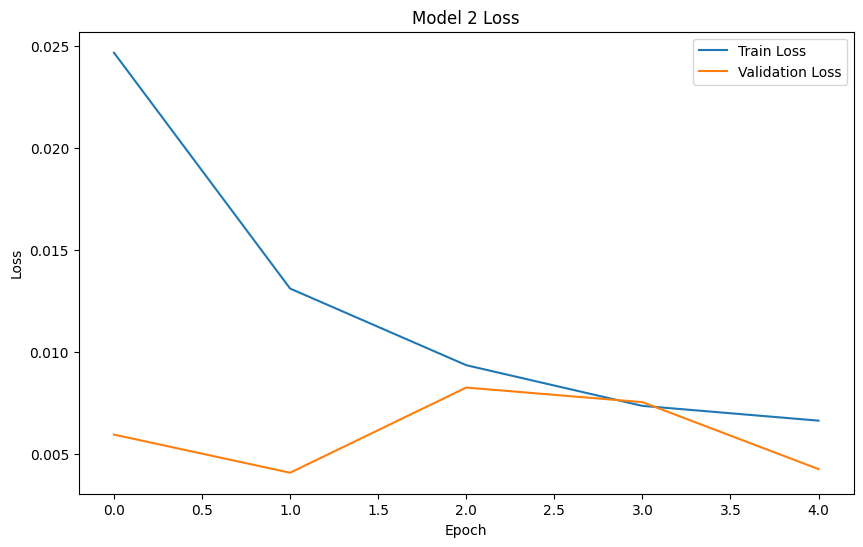

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Model 2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Make predictions on the test set
y_pred_2 = model_2.predict(x_test)

3/3 [==============================] - 1s 19ms/step


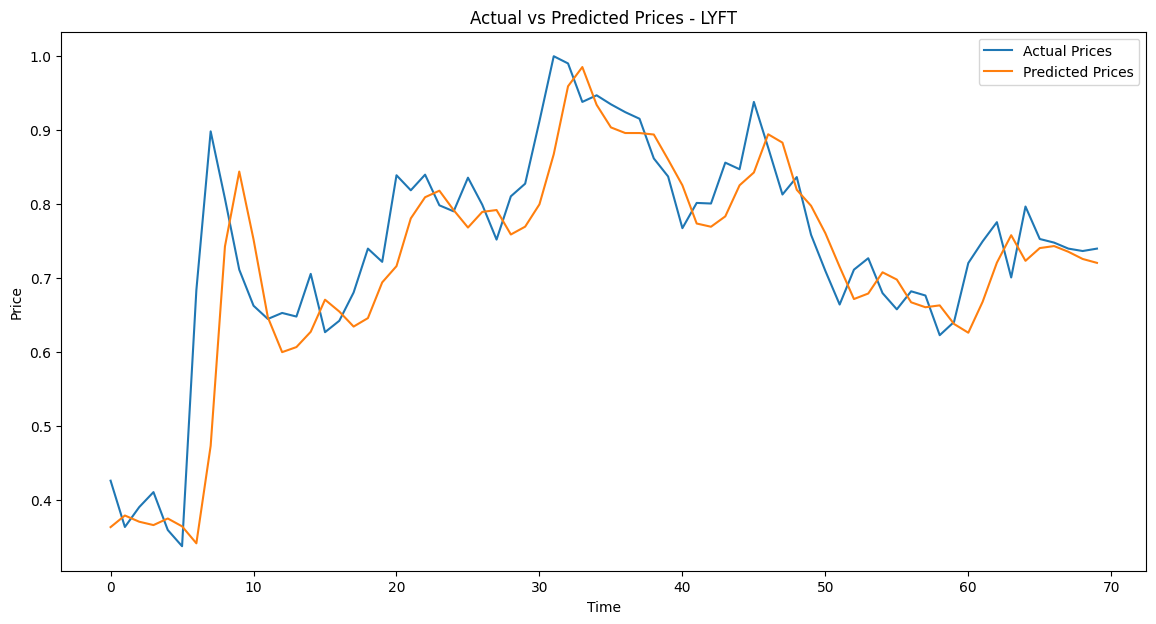

In [ ]:
# Plot actual vs. predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual Prices')
plt.plot(y_pred_2, label='Predicted Prices')
plt.title('Actual vs Predicted Prices - LYFT')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

#LSTM_4 hidden layers

In [ ]:
# Build the LSTM model
model_4 = models.Sequential()
model_4.add(layers.LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model_4.add(layers.LSTM(64, return_sequences=True))
model_4.add(layers.LSTM(32, return_sequences=True))
model_4.add(layers.LSTM(16, return_sequences=False))
model_4.add(layers.Dense(25))
model_4.add(layers.Dense(1))

In [ ]:
# Compile the model
model_4.compile(optimizer='adam', loss='mean_squared_error')

# Define callbacks
model_callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM_best_model_4.h5", save_best_only=True, monitor='val_loss', verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)
]


In [ ]:
model_4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 128)           66560     
                                                                 
 lstm_4 (LSTM)               (None, 30, 64)            49408     
                                                                 
 lstm_5 (LSTM)               (None, 30, 32)            12416     
                                                                 
 lstm_6 (LSTM)               (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 25)                425       
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 131971 (515.51 KB)
Trainable params: 131

In [ ]:
# Train the model with validation data and callbacks
history_4 = model_4.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=1, epochs=50, callbacks=model_callbacks)

Epoch 1/50
292/292 [==============================] - ETA: 0s - loss: 0.0332
Epoch 1: val_loss improved from inf to 0.00914, saving model to LSTM_best_model_4.h5
292/292 [==============================] - 23s 52ms/step - loss: 0.0332 - val_loss: 0.0091
Epoch 2/50
  3/292 [..............................] - ETA: 9s - loss: 0.0047 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


292/292 [==============================] - ETA: 0s - loss: 0.0175
Epoch 2: val_loss improved from 0.00914 to 0.00864, saving model to LSTM_best_model_4.h5
292/292 [==============================] - 13s 46ms/step - loss: 0.0175 - val_loss: 0.0086
Epoch 3/50
292/292 [==============================] - ETA: 0s - loss: 0.0127
Epoch 3: val_loss improved from 0.00864 to 0.00645, saving model to LSTM_best_model_4.h5
292/292 [==============================] - 13s 44ms/step - loss: 0.0127 - val_loss: 0.0064
Epoch 4/50
292/292 [==============================] - ETA: 0s - loss: 0.0094
Epoch 4: val_loss improved from 0.00645 to 0.00498, saving model to LSTM_best_model_4.h5
292/292 [==============================] - 13s 44ms/step - loss: 0.0094 - val_loss: 0.0050
Epoch 5/50
291/292 [============================>.] - ETA: 0s - loss: 0.0078
Epoch 5: val_loss improved from 0.00498 to 0.00327, saving model to LSTM_best_model_4.h5
292/292 [==============================] - 12s 41ms/step - loss: 0.0078 - 

In [ ]:
# Evaluate the model on the training dataset
train_loss_4 = model_4.evaluate(x_train, y_train, verbose=0)
print(f"Training Loss: {train_loss_4:.4f}")

# Evaluate the model on the validation dataset
val_loss_4 = model_4.evaluate(x_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss_4:.4f}")

# Evaluate the model on the test dataset
test_loss_4 = model_4.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss_4:.4f}")

Training Loss: 0.0035
Validation Loss: 0.0022
3/3 [==============================] - 0s 19ms/step - loss: 0.0053
Test Loss: 0.0053


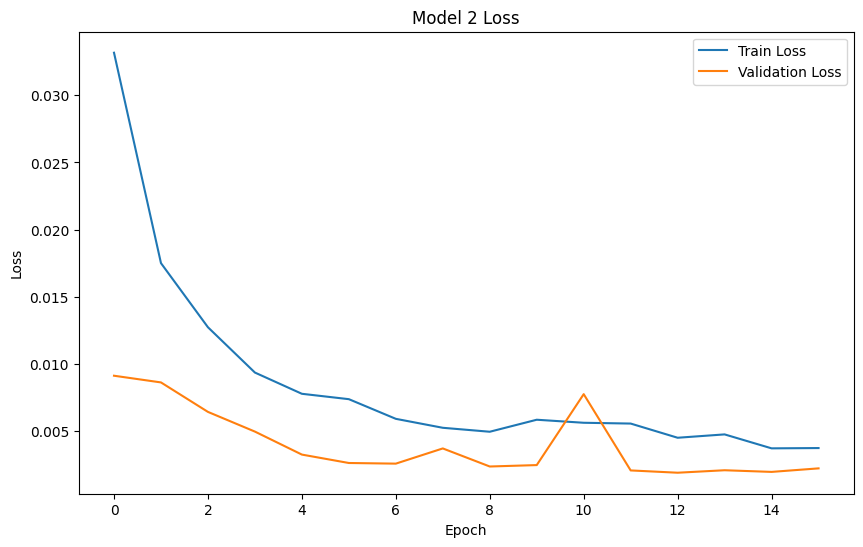

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history_4.history['loss'], label='Train Loss')
plt.plot(history_4.history['val_loss'], label='Validation Loss')
plt.title('Model 2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Make predictions on the test set
y_pred_4 = model_4.predict(x_test)

3/3 [==============================] - 2s 31ms/step


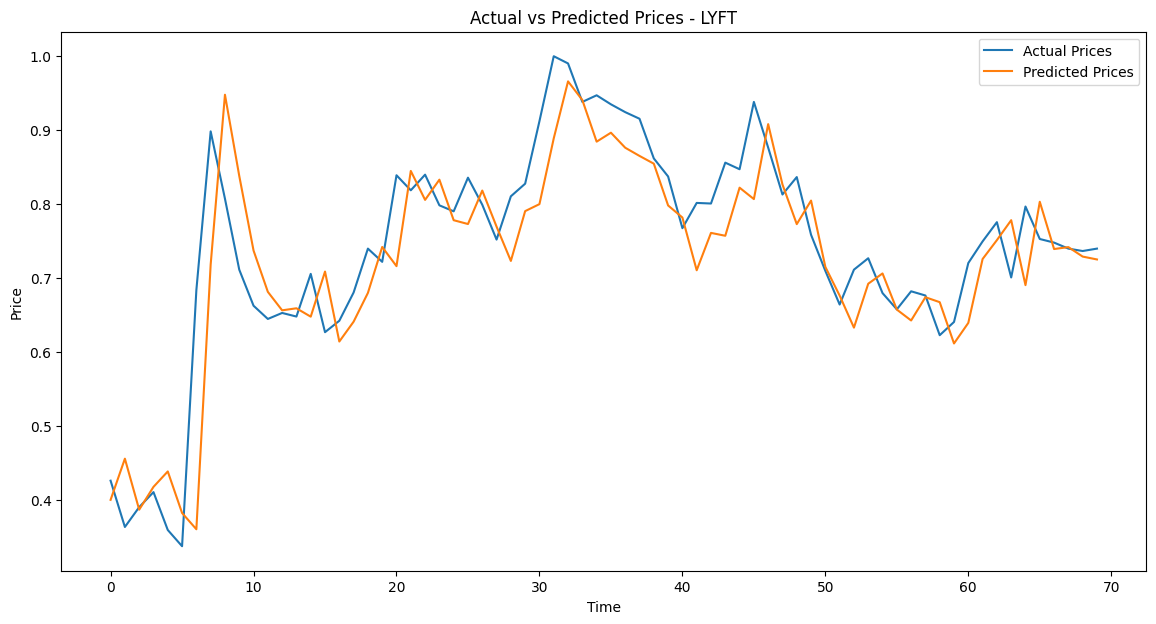

In [ ]:
# Plot actual vs. predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual Prices')
plt.plot(y_pred_4, label='Predicted Prices')
plt.title('Actual vs Predicted Prices - LYFT')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

#LSTM with 10% dropout rate

In [ ]:
# Build the LSTM model with four hidden layers and dropout
model_5 = models.Sequential()
model_5.add(layers.LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model_5.add(layers.Dropout(0.1))
model_5.add(layers.LSTM(64, return_sequences=True))
model_5.add(layers.Dropout(0.1))
model_5.add(layers.LSTM(32, return_sequences=True))
model_5.add(layers.Dropout(0.1))
model_5.add(layers.LSTM(16, return_sequences=False))
model_5.add(layers.Dropout(0.1))
model_5.add(layers.Dense(25))
model_5.add(layers.Dense(1))

In [ ]:
# Compile the model
model_5.compile(optimizer='adam', loss='mean_squared_error')


model_callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM_best_model_5.h5", save_best_only=True, monitor='val_loss', verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)
]


In [ ]:
model_5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 32)            12416     
                                                                 
 dropout_2 (Dropout)         (None, 30, 32)            0         
                                                                 
 lstm_3 (LSTM)               (None, 16)                3

In [ ]:
# Train the model
history_5 = model_5.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=1, epochs=50, callbacks=model_callbacks)

Epoch 1/50
290/292 [============================>.] - ETA: 0s - loss: 0.0321
Epoch 1: val_loss improved from inf to 0.01212, saving model to LSTM_best_model_5.h5
292/292 [==============================] - 14s 16ms/step - loss: 0.0319 - val_loss: 0.0121
Epoch 2/50
 13/292 [>.............................] - ETA: 2s - loss: 0.0273

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


291/292 [============================>.] - ETA: 0s - loss: 0.0214
Epoch 2: val_loss improved from 0.01212 to 0.00712, saving model to LSTM_best_model_5.h5
292/292 [==============================] - 4s 14ms/step - loss: 0.0214 - val_loss: 0.0071
Epoch 3/50
288/292 [============================>.] - ETA: 0s - loss: 0.0147
Epoch 3: val_loss did not improve from 0.00712
292/292 [==============================] - 3s 10ms/step - loss: 0.0146 - val_loss: 0.0080
Epoch 4/50
289/292 [============================>.] - ETA: 0s - loss: 0.0126
Epoch 4: val_loss improved from 0.00712 to 0.00619, saving model to LSTM_best_model_5.h5
292/292 [==============================] - 3s 11ms/step - loss: 0.0125 - val_loss: 0.0062
Epoch 5/50
290/292 [============================>.] - ETA: 0s - loss: 0.0110
Epoch 5: val_loss did not improve from 0.00619
292/292 [==============================] - 3s 11ms/step - loss: 0.0110 - val_loss: 0.0073
Epoch 6/50
290/292 [============================>.] - ETA: 0s - loss: 0

In [ ]:
# Evaluate the model on the training dataset
train_loss_5 = model_5.evaluate(x_train, y_train, verbose=0)
print(f"Training Loss: {train_loss_5:.4f}")

# Evaluate the model on the validation dataset
val_loss_5 = model_5.evaluate(x_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss_5:.4f}")

# Evaluate the model on the test dataset
test_loss_5 = model_5.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss_5:.4f}")

Training Loss: 0.0054
Validation Loss: 0.0027
3/3 [==============================] - 0s 8ms/step - loss: 0.0210
Test Loss: 0.0210


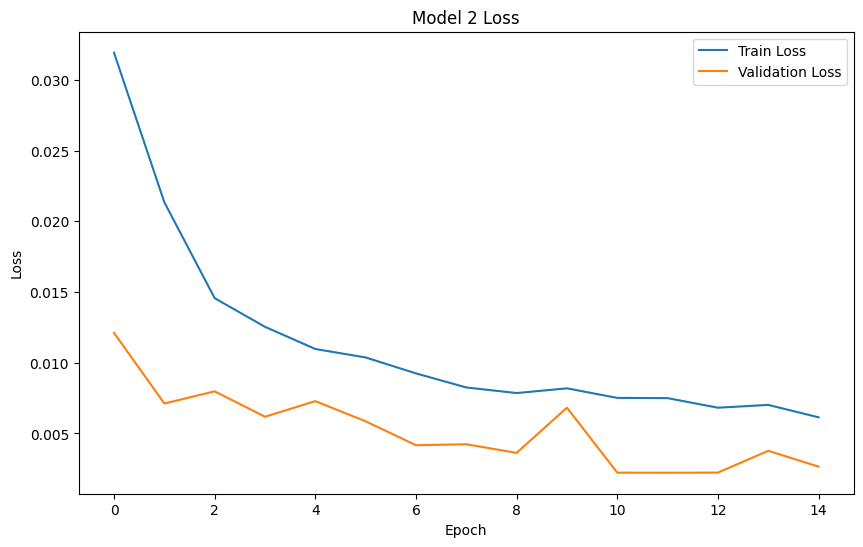

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history_5.history['loss'], label='Train Loss')
plt.plot(history_5.history['val_loss'], label='Validation Loss')
plt.title('Model 2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Make predictions on the test set
y_pred_5 = model_5.predict(x_test)

3/3 [==============================] - 1s 7ms/step


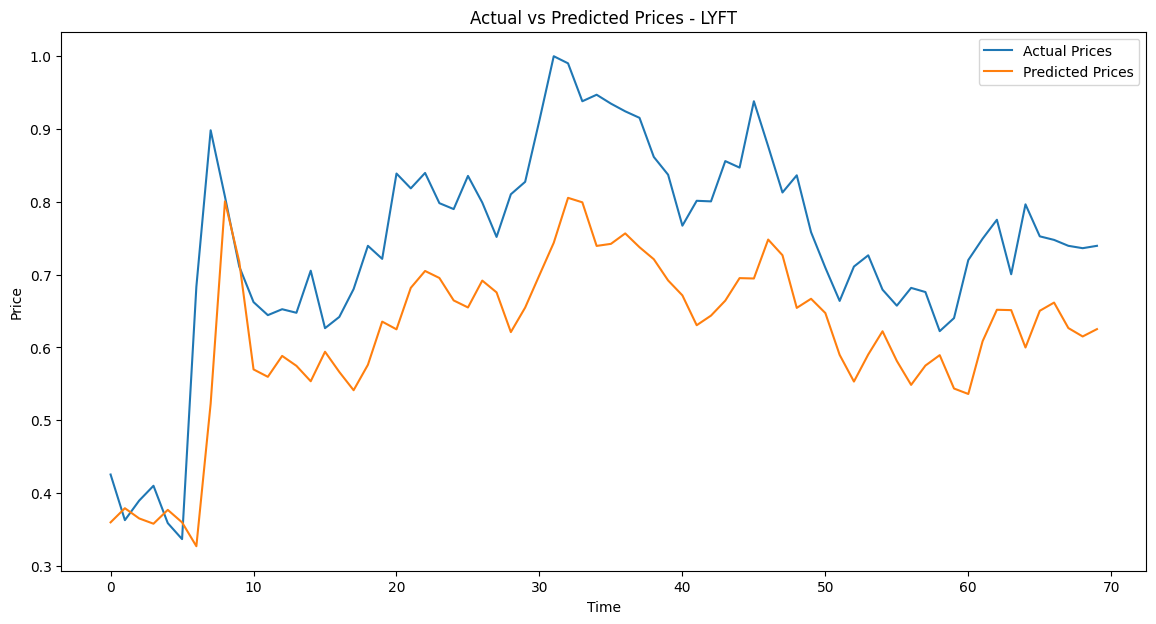

In [ ]:
# Plot actual vs. predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual Prices')
plt.plot(y_pred_5, label='Predicted Prices')
plt.title('Actual vs Predicted Prices - LYFT')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

#LSTM with 100 epochs/ 32 batch size

In [ ]:
# Build the LSTM model
model_6 = models.Sequential()
model_6.add(layers.LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model_6.add(layers.LSTM(64, return_sequences=True))
model_6.add(layers.LSTM(32, return_sequences=True))
model_6.add(layers.LSTM(16, return_sequences=False))
model_6.add(layers.Dense(25))
model_6.add(layers.Dense(1))

In [ ]:
# Compile the model
model_6.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model_6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 30, 32)            12416     
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 25)                425       
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 131971 (515.51 KB)
Trainable params: 13197

In [ ]:
# Define callbacks for early stopping and best model checkpointing
model_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
    tf.keras.callbacks.ModelCheckpoint('best_model_6.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
]

In [ ]:
# Train the model
history_6 = model_6.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=100, callbacks=model_callbacks)

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.0741
Epoch 1: val_loss improved from inf to 0.01827, saving model to best_model_6.h5
10/10 [==============================] - 12s 279ms/step - loss: 0.0741 - val_loss: 0.0183
Epoch 2/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.0232

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - ETA: 0s - loss: 0.0398
Epoch 2: val_loss improved from 0.01827 to 0.01821, saving model to best_model_6.h5
10/10 [==============================] - 1s 112ms/step - loss: 0.0398 - val_loss: 0.0182
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0316
Epoch 3: val_loss improved from 0.01821 to 0.01730, saving model to best_model_6.h5
10/10 [==============================] - 2s 188ms/step - loss: 0.0316 - val_loss: 0.0173
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0312
Epoch 4: val_loss improved from 0.01730 to 0.01720, saving model to best_model_6.h5
10/10 [==============================] - 2s 175ms/step - loss: 0.0312 - val_loss: 0.0172
Epoch 5/100
10/10 [==============================] - ETA: 0s - loss: 0.0273
Epoch 5: val_loss improved from 0.01720 to 0.01547, saving model to best_model_6.h5
10/10 [==============================] - 2s 159ms/step - loss: 0.0273 - val_loss: 0.0155
Epoch 6/100
10/1

In [ ]:
# Evaluate the model on the training dataset
train_loss_6 = model_6.evaluate(x_train, y_train, verbose=0)
print(f"Training Loss: {train_loss_6:.4f}")

# Evaluate the model on the validation dataset
val_loss_6 = model_6.evaluate(x_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss_6:.4f}")

# Evaluate the model on the test dataset
test_loss_6 = model_6.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss_6:.4f}")

Training Loss: 0.0086
Validation Loss: 0.0056
3/3 [==============================] - 0s 21ms/step - loss: 0.0281
Test Loss: 0.0281


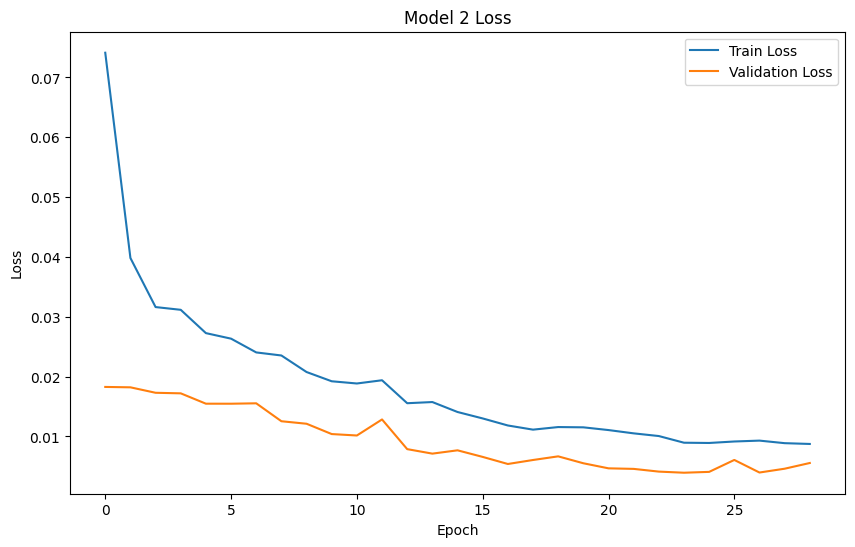

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history_6.history['loss'], label='Train Loss')
plt.plot(history_6.history['val_loss'], label='Validation Loss')
plt.title('Model 2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Make predictions on the test set
y_pred_6 = model_6.predict(x_test)

3/3 [==============================] - 3s 40ms/step


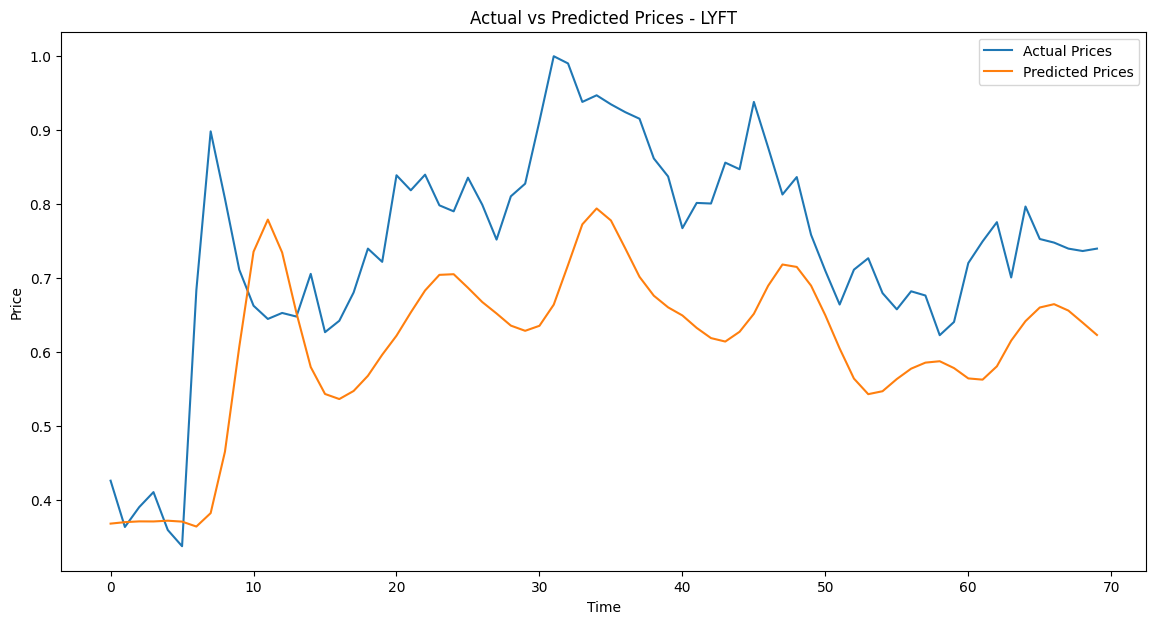

In [ ]:
# Plot actual vs. predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual Prices')
plt.plot(y_pred_6, label='Predicted Prices')
plt.title('Actual vs Predicted Prices - LYFT')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

#LSTM 4 layers NSANY

In [ ]:
# Read the stock data from yahoo finance
yf.pdr_override()
stock_list = ['NSANY']
end = datetime.now()
start = datetime(end.year - 2, end.month, end.day)

for stock in stock_list:
    globals()[stock] = yf.download(stock, start, end)

company_list = [NSANY]
company_name = ["NSANY"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

df = pd.concat(company_list, axis=0)



[*********************100%%**********************]  1 of 1 completed


In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2022-05-23,7.76,7.84,7.70,7.81,7.81,80400,NSANY
2022-05-24,7.60,7.99,7.60,7.68,7.68,69100,NSANY
2022-05-25,7.65,7.75,7.65,7.70,7.70,98700,NSANY
2022-05-26,7.70,7.81,7.70,7.79,7.79,120000,NSANY
2022-05-27,7.89,7.91,7.76,7.85,7.85,47700,NSANY


In [ ]:
data = df.filter(['Close'])
data.shape

dataset = data.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

scaled_data [:5]

# Set the size for training data
training_size = int(len(dataset) * 0.80)
test_size = len(dataset) - training_size

# Split the data into training and test sets
train_data = scaled_data[:training_size]
test_data = scaled_data[training_size:]

# Further split the training data into training and validation sets
validation_size = int(len(train_data) * 0.20)  # 20% of the training data
train_data, val_data = train_data[:-validation_size], train_data[-validation_size:]

# Print sizes for verification
print(f"Training size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")

# Optional: Print shapes to debug
print(f"Train data shape: {train_data.shape}, Validation data shape: {val_data.shape}, Test data shape: {test_data.shape}")

# Define time step
time_step = 30

# Function to convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]   # Create sequences
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Create the training dataset
x_train, y_train = create_dataset(train_data, time_step)
# Create the validation dataset
x_val, y_val = create_dataset(val_data, time_step)
# Create the testing dataset
x_test, y_test = create_dataset(test_data, time_step)

# Print shapes for verification
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
# Reshape the datasets to be [samples, time steps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)


Training size: 321, Validation size: 80, Test size: 101
Train data shape: (321, 1), Validation data shape: (80, 1), Test data shape: (101, 1)
x_train shape: (290, 30), y_train shape: (290,)
x_val shape: (49, 30), y_val shape: (49,)
x_test shape: (70, 30), y_test shape: (70,)


In [ ]:
# Build the LSTM model
model_7 = models.Sequential()
model_7.add(layers.LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model_7.add(layers.LSTM(64, return_sequences=True))
model_7.add(layers.LSTM(32, return_sequences=True))
model_7.add(layers.LSTM(16, return_sequences=False))
model_7.add(layers.Dense(25))
model_7.add(layers.Dense(1))

In [ ]:
# Compile the model
model_7.compile(optimizer='adam', loss='mean_squared_error')

# Define callbacks
model_callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM_best_model_7.h5", save_best_only=True, monitor='val_loss', verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)
]
model_7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 30, 32)            12416     
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 25)                425       
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 131971 (515.51 KB)
Trainable params: 13197

In [ ]:
# Train the model with validation data and callbacks
history_7 = model_7.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=1, epochs=50, callbacks=model_callbacks)

Epoch 1/50
289/290 [============================>.] - ETA: 0s - loss: 0.0157
Epoch 1: val_loss improved from inf to 0.01278, saving model to LSTM_best_model_7.h5
290/290 [==============================] - 13s 16ms/step - loss: 0.0157 - val_loss: 0.0128
Epoch 2/50
 10/290 [>.............................] - ETA: 3s - loss: 0.0093

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


290/290 [==============================] - ETA: 0s - loss: 0.0092
Epoch 2: val_loss improved from 0.01278 to 0.00538, saving model to LSTM_best_model_7.h5
290/290 [==============================] - 4s 13ms/step - loss: 0.0092 - val_loss: 0.0054
Epoch 3/50
290/290 [==============================] - ETA: 0s - loss: 0.0060
Epoch 3: val_loss did not improve from 0.00538
290/290 [==============================] - 4s 13ms/step - loss: 0.0060 - val_loss: 0.0057
Epoch 4/50
287/290 [============================>.] - ETA: 0s - loss: 0.0045
Epoch 4: val_loss improved from 0.00538 to 0.00247, saving model to LSTM_best_model_7.h5
290/290 [==============================] - 3s 11ms/step - loss: 0.0045 - val_loss: 0.0025
Epoch 5/50
290/290 [==============================] - ETA: 0s - loss: 0.0036
Epoch 5: val_loss improved from 0.00247 to 0.00237, saving model to LSTM_best_model_7.h5
290/290 [==============================] - 3s 11ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 6/50
288/290 [=========

In [ ]:
# Evaluate the model on the training dataset
train_loss_7 = model_7.evaluate(x_train, y_train, verbose=0)
print(f"Training Loss: {train_loss_7:.4f}")

# Evaluate the model on the validation dataset
val_loss_7 = model_7.evaluate(x_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss_7:.4f}")

# Evaluate the model on the test dataset
test_loss_7 = model_7.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss_7:.4f}")

Training Loss: 0.0016
Validation Loss: 0.0021
3/3 [==============================] - 0s 7ms/step - loss: 0.0017
Test Loss: 0.0017


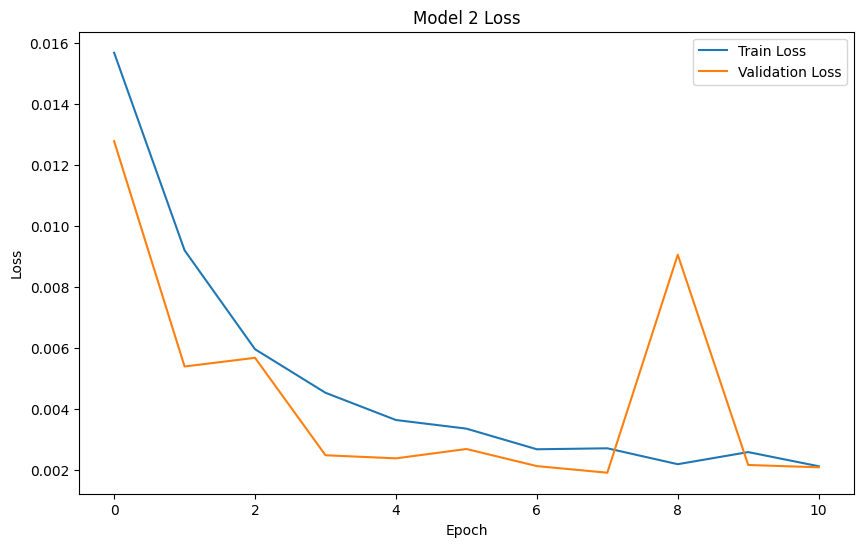

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history_7.history['loss'], label='Train Loss')
plt.plot(history_7.history['val_loss'], label='Validation Loss')
plt.title('Model 2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Make predictions on the test set
y_pred_7 = model_7.predict(x_test)

3/3 [==============================] - 1s 7ms/step


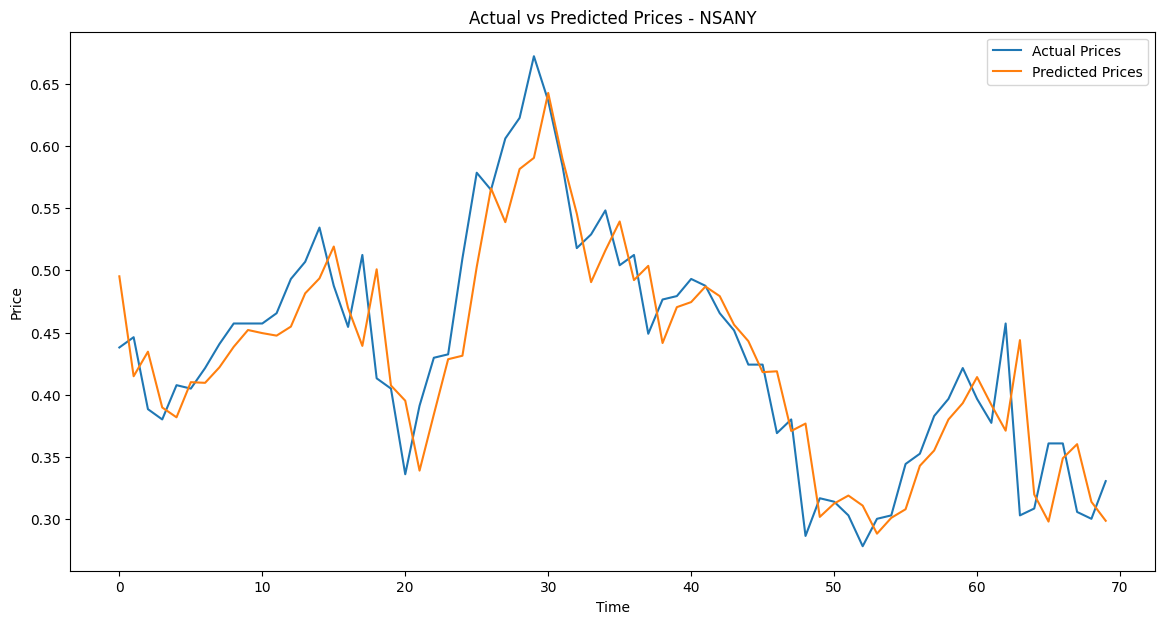

In [ ]:
# Plot actual vs. predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual Prices')
plt.plot(y_pred_7, label='Predicted Prices')
plt.title('Actual vs Predicted Prices - NSANY')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [9]:
%%shell
jupyter nbconvert --to html '/content/Assignment_04_Stock_Prediction_Petkovski (1).ipynb'


[NbConvertApp] Converting notebook /content/Assignment_04_Stock_Prediction_Petkovski (1).ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 20 image(s).
[NbConvertApp] Writing 2182737 bytes to /content/Assignment_04_Stock_Prediction_Petkovski (1).html
